<a href="https://colab.research.google.com/github/tarunmukku/BERT-multi-class-compliants-classification/blob/main/BERT_multi_class_classification_compliants_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Multi-Class classification of costumer complaints using BERT transformer model

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
#import tensorflow_hub as hub
from datetime import datetime
#from google.colab import drive
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
!rm -rf 'dl_content'
!rm -rf 'datasets'

####Clone the git repository

In [ ]:
!git clone https://github.com/tarunmukku/citi-hackathon.git

Cloning into 'citi-hackathon'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 29 (delta 8), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (29/29), done.


####Load Test train datasets

In [ ]:
df_train = pd.read_csv('citi-hackathon/train.csv', sep='\t', encoding='utf-8')
df_test = pd.read_csv('citi-hackathon/test.csv', sep='\t', encoding='utf-8')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Sub-product                   14000 non-null  object
 1   Consumer complaint narrative  14000 non-null  object
 2   Complaint ID                  14000 non-null  int64 
 3   word_count                    14000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 437.6+ KB


In [ ]:
df_train['Consumer complaint narrative'] = df_train['Consumer complaint narrative'].astype('string')
df_test['Consumer complaint narrative'] = df_test['Consumer complaint narrative'].astype('string')

####Converting our the sub-product column into Categorical data

In [ ]:
encoded_dict = {'Credit card':0,'Savings account':1, 'Medical debt':2, 'Domestic (US) money transfer':3, 'Vehicle loan':4}
df_train['Sub-product'] = df_train['Sub-product'].map(encoded_dict)
df_test['Sub-product'] = df_test['Sub-product'].map(encoded_dict)

In [ ]:
df_test.head()

,Sub-product,Consumer complaint narrative,Complaint ID,word_count
0,2,"So, my wife and I have had our credit pulled t...",5303506,210
1,3,XX/XX/2022 - 4 XXXX transactions were made eac...,5405508,234
2,3,"XXXX XXXX Abuse My name is XXXX XXXX XXXX, a ...",5363397,2188
3,2,I am submitting this compliant on my own. Ther...,5178930,125
4,2,this deb company wants to charge me for a serv...,5319632,71


In [ ]:
!pip install transformers

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


###Installing Huggingface transformers Librairies for using BERT model

In [ ]:
import transformers
from transformers import BertTokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train = to_categorical(df_train['Sub-product'])
y_test = to_categorical(df_test['Sub-product'])

In [ ]:
from transformers import AutoTokenizer,TFBertModel
#TFBertModel pre-trained Bert model for TensorFlow.
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


###Input Data modelling

In [ ]:
x_train = tokenizer(
    text=df_train['Consumer complaint narrative'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=df_test['Consumer complaint narrative'].tolist(),
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

###Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
max_len = 100
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(5,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

###Model Compilation

In [ ]:
optimizer = Adam(
    learning_rate=5e-05, #  learning rate is for bert model as per huggingface 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

###Model Training

In [ ]:
 train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=5,
    batch_size=36
)

Epoch 1/5
389/389 [==============================] - 177s 455ms/step - loss: 1.0064 - balanced_accuracy: 0.9076 - val_loss: 1.0014 - val_balanced_accuracy: 0.8945
Epoch 2/5
389/389 [==============================] - 176s 452ms/step - loss: 0.9552 - balanced_accuracy: 0.9496 - val_loss: 1.0001 - val_balanced_accuracy: 0.8932
Epoch 3/5
389/389 [==============================] - 176s 452ms/step - loss: 0.9442 - balanced_accuracy: 0.9626 - val_loss: 0.9987 - val_balanced_accuracy: 0.8975
Epoch 4/5
389/389 [==============================] - 176s 452ms/step - loss: 0.9394 - balanced_accuracy: 0.9667 - val_loss: 0.9990 - val_balanced_accuracy: 0.8978
Epoch 5/5
389/389 [==============================] - 176s 452ms/step - loss: 0.9360 - balanced_accuracy: 0.9704 - val_loss: 0.9991 - val_balanced_accuracy: 0.8997


###Model Evaluation

In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

array([1.8093109e-04, 1.8699433e-03, 9.9992967e-01, 4.7006362e-04,
       1.1995020e-03], dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = df_test['Sub-product']

In [ ]:
cm = tf.math.confusion_matrix(df_test['Sub-product'], y_predicted)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Plot for Train and vaildation accuracy

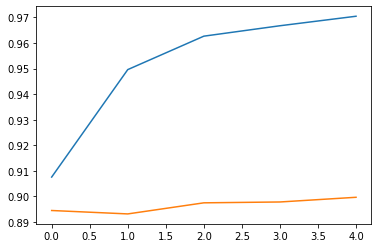

In [ ]:
plt.plot(train_history.history['balanced_accuracy'])
plt.plot(train_history.history['val_balanced_accuracy'])

Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1170
           1       0.88      0.89      0.89      1168
           2       0.92      0.92      0.92      1260
           3       0.90      0.87      0.88      1220
           4       0.95      0.93      0.94      1182

    accuracy                           0.90      6000
   macro avg       0.90      0.90      0.90      6000
weighted avg       0.90      0.90      0.90      6000



Text(32.99999999999999, 0.5, 'True')

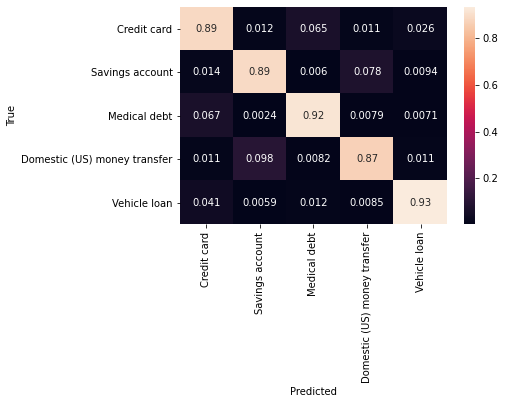

In [ ]:
import seaborn as sns
SENTIMENT_LABELS = [
'Credit card','Savings account', 'Medical debt', 'Domestic (US) money transfer', 'Vehicle loan']

sns.heatmap(
    cm, annot=True,
    xticklabels=SENTIMENT_LABELS,
    yticklabels=SENTIMENT_LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

In [ ]:
texts = input(str('input the text'))
x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=100,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
for key , value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

input the text i sent money but could not able to find transaction details in account


Credit card 0.29157475
Savings account 0.20488036
Medical debt 0.26025862
Domestic (US) money transfer 99.907364
Vehicle loan 0.07705993


In [ ]:
#!zip -r model.zip 'saved_model'

In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
new_model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
new_model.layers[2].trainable = True

In [ ]:
new_model.load_weights('model_weights.h5')

In [ ]:
new_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     multiple             109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 768)          0           tf_bert_model[1][0]   